In [1]:
import os
import time
import warnings
import numpy as np
import pandas as pd
from numpy import newaxis
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import itertools

In [17]:
def load_data(filename, seq_len, normalise_window):
    df = pd.read_excel(filename,header = None)
    #print(df.tail())
    data = df[0].tolist()
    print(len(data))

    sequence_length = seq_len + 1
    #print(sequence_length)
    
    result = []
    for index in range(len(data) - sequence_length + 1):
        result.append(data[index: index + sequence_length])
    
    print(len(result))
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)
    
    row = round(1 * result.shape[0])
    train = result[:int(row), :]
    print(result.shape)
    print(train.shape)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[:, :-1]
    y_test = result[:, -1]
    
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

In [18]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [19]:
fname = 'ProjectInput/google.xlsx'
X_train, y_train, X_test, y_test = load_data(fname, 50, True)

3022
2972
(2972, 51)
(2972, 51)


In [20]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(50,
                   input_shape=(layers[1], layers[0]),
                   return_sequences=True))    
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(1))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

In [21]:
model = build_model([1, 50, 100, 1])

> Compilation Time :  0.009978055953979492


In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
__________________________________________________

In [23]:
model.fit(
        X_train,
        y_train,
        batch_size=512,
        epochs=1,
        validation_split=0.05)

6/6 [==============================] - 13s 802ms/step - loss: 16.9535 - val_loss: 0.2407


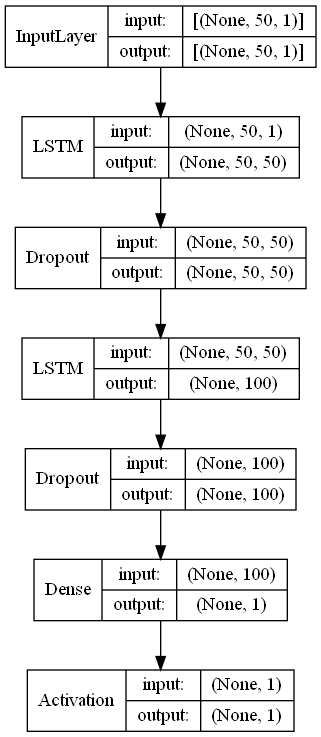

In [35]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False) 

In [33]:
import tensorflow as tf

In [34]:
tf.print??

In [24]:
def plot_results(predicted_data, true_data,method,company):
    figure, axis = plt.subplots(1, 1,figsize = (7,5))
    figure.tight_layout()
    axis.plot(true_data[0:150])
    axis.plot(predicted_data[0:150])
    axis.legend(['True Data','Prediction'])
    axis.set_ylabel('value')
    if method == 'sequence':
        graph_title = 'Whole history based prediction'
    else:
        graph_title = 'Day based prediction' 
    axis.set_title(graph_title)
    df_pr = pd.DataFrame(predicted_data)
    fname = 'OutputLSTM/' + company + '_' + method + '_pred.csv' 
    df_pr.to_csv(fname, index=False, header=False)
    df_tr = pd.DataFrame(true_data)
    fname = 'OutputLSTM/'  + company + '_' + method + '_true.csv'
    df_tr.to_csv(fname, index=False, header=False)
    plt.show()

def plot_results_multiple(predicted_data, true_data, prediction_len,method,company):
    figure, axis = plt.subplots(1, 1,figsize = (7,5))
    figure.tight_layout()
    axis.plot(true_data[0:150],label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    pr_list=[]
    for i, data in enumerate(predicted_data[0:3]):
        padding = [None for p in range(i * prediction_len)]
        axis.plot(padding + data, label='Prediction')
        pr_list.append(data)
        plt.legend()
    axis.set_ylabel('value')
    graph_title = 'Window based prediction'
    axis.set_title(graph_title)
    pr_list_flat = list(itertools.chain.from_iterable(predicted_data)) # converting a list of list in to a 1-d list
    df_pr = pd.DataFrame(pr_list_flat)
    fname = 'OutputLSTM/' + company + '_' + method + '_pred.csv'
    df_pr.to_csv(fname, index=False, header=False)
    df_tr = pd.DataFrame(true_data)
    fname = 'OutputLSTM/' + company + '_' + method + '_act.csv'
    df_tr.to_csv(fname, index=False, header=False)
    plt.show()
    

In [25]:
def predict_point_by_point(model, data): #Day based
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size): #Whole History based
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len): #Window based
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [31]:
company='google'   #company_code
method='point'	# window, sequence, point
seq_len = 50

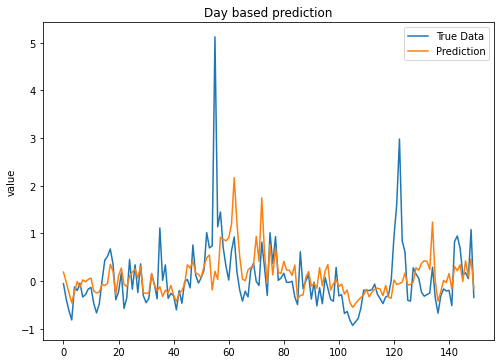

In [32]:
if method == 'window':
    predictions = predict_sequences_multiple(model, X_test, seq_len, 50)
    plot_results_multiple(predictions, y_test, 50, method, company)

if method == 'sequence':
    predictions = predict_sequence_full(model, X_test, seq_len)
    plot_results(predictions, y_test, method, company)

if method == 'point':
    predictions = predict_point_by_point(model, X_test) 
    plot_results(predictions, y_test, method, company)